# Восстановление золота из руды

## 1. Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from urllib.parse import urlencode
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## 2. Функции

In [2]:
def get_url(link):
    """
    Получение адреса для скачивания с Яндекс.Диск
    link - ссылка на Яндекс.Диск
    """
    print("Run", link)
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return url

In [3]:
def total_smape(rougher, final):
    return 0.25*rougher + 0.75*final

In [4]:
def learn_LinR(X_train, y_train, y_const):
    """
    Функция для обучения линейной регрессией
    """
    m = LinearRegression()

    results = cross_validate(m, X_train, y_train, cv=5, 
                             scoring=make_scorer(smape), 
                             return_estimator=True)
    lg = results['estimator'][0]
    smape_valid = results['test_score'].mean()

#     smape_valid = smape(y_train, lg.predict(X_train))
    smape_const = smape(y_train, y_const)
    
    return (lg, smape_valid, smape_const)

In [5]:
# Аналогичный график, но только для обучающей выборки и с другой компоновкой
def show_concentrates():
    substance = ['ag', 'au', 'pb']
    concentrate_features2 = [
        ['rougher.input.feed_ag','rougher.input.feed_au','rougher.input.feed_pb'],
        ['rougher.output.concentrate_ag','rougher.output.concentrate_au', 'rougher.output.concentrate_pb'],
        ['final.output.concentrate_ag','final.output.concentrate_au','final.output.concentrate_pb']]
    stages = ['rougher_input', 'rougher_output', 'final_output']
    colors = ['gray', 'orange', 'brown']
    _, axes = plt.subplots(1, 3, figsize=(20,5))

    for ax, stage, concentrates in zip(axes, stages, concentrate_features2):
        legends = []
        for col, color in zip(concentrates, colors):
            sns.distplot(gold_recovery_train[col], ax=ax, color=color)
            legends.append(col)
            ax.legend(legends)
            ax.title.set_text(stage)
        ax.set_xlabel(f'The concentrate of substabce')
    plt.show()

In [6]:
def get_true_range(s, k=1.5):
    """
    Функция для получения границ диапазона [-k*iqr, +k*iqr]
    
    s - данные типа Series
    k - коэффициент для вычисления доверительного интервала (default=1.5)
    """
    iqr = st.iqr(s)
    quantile = s.quantile([.25, .75])
    first = round(quantile[0.25] - k * iqr, 2)
    third = round(quantile[0.75] + k * iqr, 2)
    return (first, third)

In [7]:
def smape(y_true, y_pred):
    """
    Вычисление метрики sMAPE:
    y_true - истиные значения
    y_pred - предсказания
    """
    
    true_list = list(y_true)
    pred_list = list(y_pred)
    result = 0
    
    for t, p in zip(true_list, pred_list):
        result += abs(t - p) / ((abs(t) + abs(p)) / 2)
    
    return result / len(true_list) * 100

In [8]:
def grid_search_cv(model, params, X_train, y_train):
    # считаем с другой метрикой, потому что так быстрее
    search = RandomizedSearchCV(model, params, cv=5, random_state=12345,
                      scoring='neg_mean_absolute_error',n_jobs=-1, 
                      verbose=2, return_train_score=True, n_iter=300)
    
    search.fit(X_train, y_train)
    print('The best train MAE:', abs(search.best_score_))
    print(search.best_params_)
    print()
    return search

In [9]:
def learn_DT(X_train, y_train, y_const):
    """
    Функция для обучения дерева решений
    """
        
    param_grid = {
        'max_depth': range(10, 20, 5),
        'min_samples_leaf': range(1, 10, 5),
        'max_features': ['sqrt', 'log2'],
        'min_impurity_split': [0.2, 0.4]
    }
    
    m = DecisionTreeRegressor(random_state=12345)
    grid_search = grid_search_cv(m, param_grid, X_train, y_train)
    dt = grid_search.best_estimator_
    smape_valid = smape(y_train, dt.predict(X_train)) 
    smape_const = smape(y_train, y_const)
    
    return (dt, smape_valid, smape_const)

In [10]:
def learn_RF(X_train, y_train, y_const):
    """
    Функция для обучения случайного леса
    """
    
    param_grid = {
        'random_state': [12345],
        'max_depth': range(15, 100, 10),
        'n_estimators': range(30, 100, 10),
        'min_samples_leaf': range(1, 10, 1),
        'max_features': ['sqrt'],
        'min_impurity_split': [.2, .4, .6],
        'min_weight_fraction_leaf': [.0, .1, .2],
        'min_impurity_decrease': [.0, .1, .2, .3],
    }
    
    m = RandomForestRegressor()
    grid_search = grid_search_cv(m, param_grid, X_train, y_train)
    rf = grid_search.best_estimator_
    smape_valid = smape(y_train, rf.predict(X_train))
    smape_const = smape(y_train, y_const)
    
    return (rf, smape_valid, smape_const)

In [11]:
def show_results(rougher, rougher_const, final, final_const, total, total_const,
                 rougher_diff, final_diff, total_diff, kind='train', prefix=''):
    print('---------------------------------------------------')
    print(f'rougher {prefix} sMAPE {kind}: {rougher}')
    print(f'rougher {prefix} sMAPE const: {rougher_const}')
    print(f'diff: {rougher_diff}%')
    print('---------------------------------------------------')
    print(f'final  {prefix} sMAPE {kind}: {final}')
    print(f'final  {prefix} sMAPE const: {final_const}')
    print(f'diff: {final_diff}%')
    print('---------------------------------------------------')
    print(f'Total sMAPE [{kind}]: {total}')
    print(f'Total sMAPE [const]: {total_const}')
    print(f'diff: {total_diff}%')
    print('---------------------------------------------------')
    

In [12]:
def smape_diff(value, const):
    return round((const - value) / const * 100)

In [13]:
def get_results(learn_func, r_X_train, r_y_train, r_y_const,
                f_X_train, f_y_train, f_y_const):
    
    prefix = f'{learn_func.__name__}'

    rougher_model, rougher_smape_train, rougher_smape_const = learn_func(
        r_X_train, r_y_train, r_y_const)
    
    final_model, final_smape_train, final_smape_const = learn_func(
        f_X_train, f_y_train, f_y_const)
    
    total_smape_train = total_smape(rougher_smape_train, final_smape_train)
    total_smape_const = total_smape(rougher_smape_const, final_smape_const)
    
    rougher_diff = smape_diff(rougher_smape_train, rougher_smape_const)
    final_diff = smape_diff(final_smape_train, final_smape_const)
    total_diff = smape_diff(total_smape_train, total_smape_const)
    
    show_results(rougher_smape_train, rougher_smape_const, final_smape_train, 
                 final_smape_const, total_smape_train, total_smape_const, 
                 rougher_diff, final_diff, total_diff, kind='train', prefix=prefix)
    
    return (rougher_model, final_model)

In [14]:
def test_model(rougher_m, final_m, 
               X_rougher, y_rougher, y_rougher_const,
               X_final, y_final, y_final_const):
    
    y_rougher_pred = rougher_m.predict(X_rougher)
    y_final_pred = final_m.predict(X_final)
    
    rougher_smape_test = smape(y_rougher, y_rougher_pred)
    rougher_smape_const = smape(y_rougher, y_rougher_const)
    rougher_diff = smape_diff(rougher_smape_test, rougher_smape_const)
    
    final_smape_test = smape(y_final, y_final_pred)
    final_smape_const = smape(y_final, y_final_const)
    final_diff = smape_diff(final_smape_test, final_smape_const)
    
    total_smape_test = total_smape(rougher_smape_test, final_smape_test)
    total_smape_const =  total_smape(rougher_smape_const, final_smape_const)
    total_diff = smape_diff(total_smape_test, total_smape_const)
    
    show_results(rougher_smape_test, rougher_smape_const, final_smape_test, 
             final_smape_const, total_smape_test, total_smape_const, 
             rougher_diff, final_diff, total_diff, kind='test')

## 3. Подготовка данных

In [15]:
LINK_TRAIN = "https://yadi.sk/d/fYK6yPaDpjBLZg"
LINK_TEST = "https://yadi.sk/d/14oMjCQg-iKfeA"
LINK_FULL = "https://yadi.sk/d/OajQwNu4qUDeJw"

In [16]:
gold_recovery_train = pd.read_csv(get_url(LINK_TRAIN))

Run https://yadi.sk/d/fYK6yPaDpjBLZg


In [17]:
gold_recovery_test = pd.read_csv(get_url(LINK_TEST))

Run https://yadi.sk/d/14oMjCQg-iKfeA


In [18]:
gold_recovery_full = pd.read_csv(get_url(LINK_FULL))

Run https://yadi.sk/d/OajQwNu4qUDeJw


In [19]:
gold_recovery_train.name = 'train'
gold_recovery_test.name = 'test'
gold_recovery_full.name = 'full'

In [20]:
gold_recovery_train.info()
gold_recovery_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [21]:
gold_recovery_test.info()
gold_recovery_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [22]:
gold_recovery_full.info()
gold_recovery_full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Посмотрим, сколько пропусков в каждом датасете.

In [23]:
print(gold_recovery_train.name, gold_recovery_train.isna().sum().sum())
print(gold_recovery_test.name, gold_recovery_test.isna().sum().sum())
print(gold_recovery_full.name, gold_recovery_full.isna().sum().sum())

train 30320
test 2360
full 36587


Во всех предоставленных наборах данных 2 типа признаков:
* категориальные (1 признак - *date*)
* количественные (все остальные)


Так как в данных есть пропуски, затрудняется процесс вычислений. Согласно заданию, данные с течением времени изменяются, а в небольшие промежутки времени данные почти не отличаются. Заполним пропуски.

In [24]:
gold_recovery_train.fillna(method='ffill', inplace=True)
gold_recovery_test.fillna(method='ffill', inplace=True)
gold_recovery_full.fillna(method='ffill', inplace=True)

print(gold_recovery_train.name, gold_recovery_train.isna().sum().sum())
print(gold_recovery_test.name, gold_recovery_test.isna().sum().sum())
print(gold_recovery_full.name, gold_recovery_full.isna().sum().sum())

train 0
test 0
full 0


Проверим, что эффективность обогащения рассчитана правильно - вычислим ее на обучающей выборке.

<img src="https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg" title="Коэффициент эффективности" />

In [25]:
gold_recovery_train['rougher.output.recovery'].isna().sum()

0

In [26]:
# rougher_recovery = ((C * (F - T)) / (F * (C - T))) * 100
# C — доля золота в концентрате после флотации/очистки;
# F — доля золота в сырье/концентрате до флотации/очистки;
# T — доля золота в отвальных хвостах после флотации/очистки.

c = gold_recovery_train['rougher.output.concentrate_au']
f = gold_recovery_train['rougher.input.feed_au']
t = gold_recovery_train['rougher.output.tail_au']
gold_recovery_train['rougher.output.recovery_calc'] = (
    (c * (f - t)) / (f * (c - t))) * 100

gold_recovery_train['rougher.output.recovery_calc'].isna().sum()

1169

Получили много nan-ов (в вычислениях есть деление на ноль), не будем учитывать такие строки для проверки формулы.

In [27]:
not_nan = gold_recovery_train[~gold_recovery_train['rougher.output.recovery_calc'].isna()].index
recovery_calc = gold_recovery_train['rougher.output.recovery_calc'][not_nan].shape
recovery = gold_recovery_train['rougher.output.recovery'][not_nan].shape

rougher_recovery_mae = mean_absolute_error(recovery_calc, recovery)
rougher_recovery_mae

0.0

В результате, рассчет recovery совпал с данными. Посмотрим на признаки, не доступные в тестовой выборке.

In [28]:
diff_list = list(set(gold_recovery_train.columns) - set(gold_recovery_test.columns))
sorted(diff_list)

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.recovery_calc',
 'rougher.output.tail_ag',
 'rougher.out

Все отличающиеся признаки - количественные:
* концентрации веществ флотации, первого и второго этапа;
* отвальные хвосты флотации, первого и второго этапов;
* **отвальные хвосты финальной стадии;**
* рассчетные характеристики флотации;
* коэффициенты эффективности флотации и финальной очистки.

Из списка отличных признаков *final.output.recovery, rougher.output.recovery* - целевые.

Исходя из имеющихся данных, в различия признаков тестовой выборки и обучающей - не значимые признаки  (с промежуточных стадий обработки) и целевые признаки. Удалим из обучающей выборки описанные признаки, кроме:
- начальных, черновых и финальных концентраций _всех_ веществ (золото, серебро, свинец) для дополнительного анализа;
- целевых признаков.

In [29]:
#  признаки, которые понадобятся в анализе данных
concentrate_features = [
    'rougher.input.feed_ag',
    'rougher.input.feed_au',
    'rougher.input.feed_pb',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_pb',
    'final.output.concentrate_ag',
    'final.output.concentrate_au',
    'final.output.concentrate_pb'
]

# целевые признаки
rougher_target = 'rougher.output.recovery'
final_target = 'final.output.recovery'

In [30]:
# признаки для анализа и целевой не трогаем
drop_list = list(set(diff_list) - set([rougher_target]) - set([final_target]))
sorted(drop_list)

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery_calc',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.out

## 4. Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки (для всех данных).

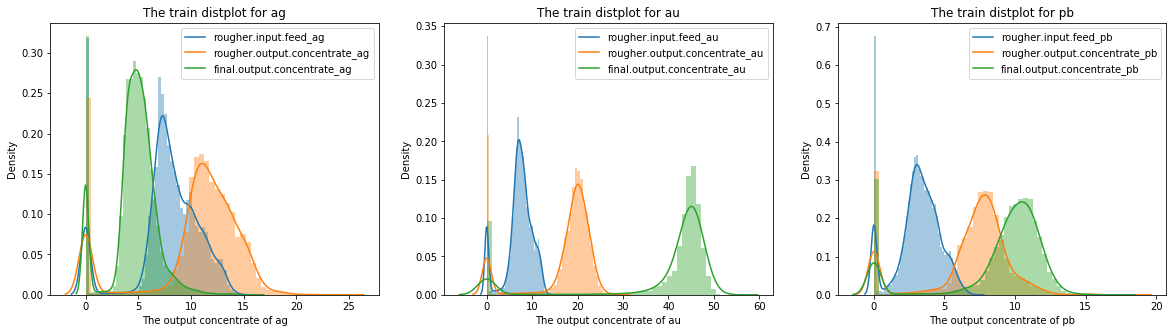

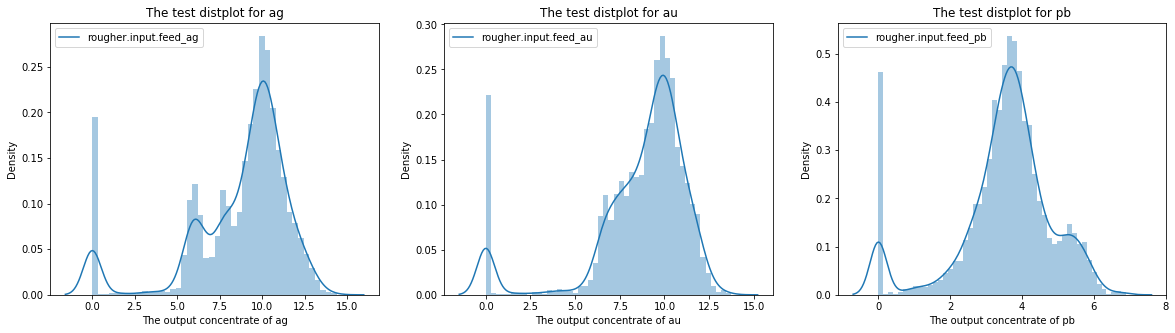

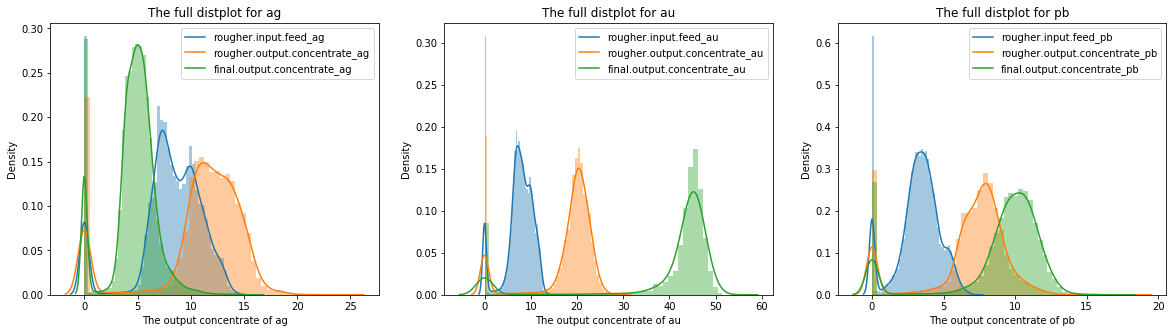

In [31]:
substance = ['ag', 'au', 'pb']

for df in [gold_recovery_train, gold_recovery_test, gold_recovery_full]:
    try:
        concentrates = df[concentrate_features]
    except KeyError as e:
        wrong_features = re.sub(r'[\"\[\'\] ]|not in index', '', str(e)).split(',')
        ok_features = list(set(concentrate_features) - set(wrong_features))
        concentrates = df[ok_features]
        
    _, axes = plt.subplots(1, 3, figsize=(20,5))

    for ax, sub in zip(axes, substance):
        legends = []
        title = f"The {df.name} distplot for {sub}"
        
        for col in concentrates:
            if sub in col:
                sns.distplot(df[col], ax=ax)
                legends.append(col)
                ax.legend(legends)
                ax.title.set_text(title)
        ax.set_xlabel(f'The output concentrate of {sub}')
    plt.show()

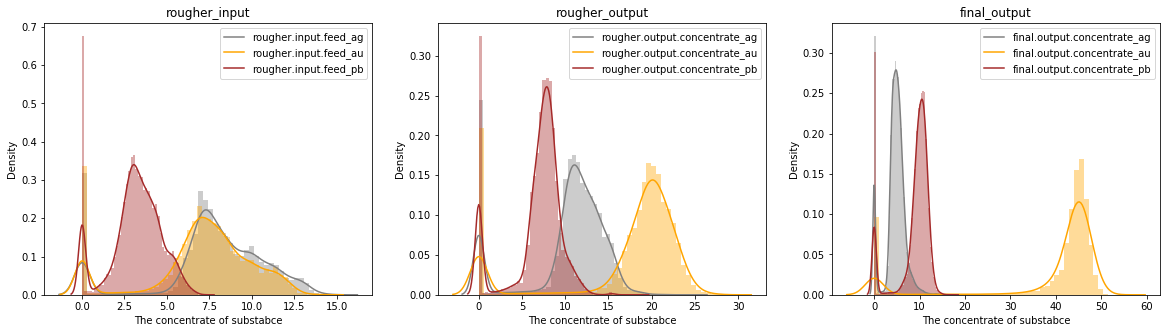

In [32]:
show_concentrates()

Распределение концентрации для каждого из веществ имеет одинаковую форму в обучающей и полной выборках. В тестовой выборке данные о черновой и финальной концентрациях отсутствуют, но начальная концентрация веществ имеет схожую форму с дугими выборками. Из графиков видны изменения концентрации, в зависимости от стадии очистки:
* ***Золото*** - ожидаемая картина - кончентрация увеличивается от начальной стадии к конечной.
* ***Серебро*** - черновая концентрация выше, чем начальная, но финальная - ниже начальной и черновой. 
* ***Свинец*** - замечена **аномалия** на графике распределения концентраций, согласно которому концентрация возрастает от начального этапа очистки к финальному. Возможны варианты:
    * ошибка в данных признаки начальной концентрации и конечной перепутаны;
    * ошибка в этапах очистки.
    
Также, подозрительно много нулевых концентраций для каждого вещества на каждом этапе очистки - похоже на выбросы.

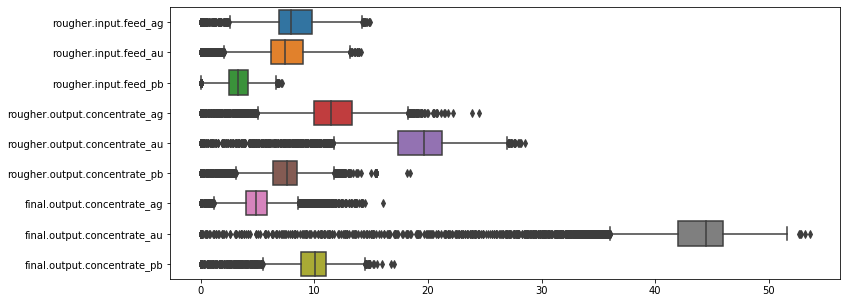

In [33]:
_, ax = plt.subplots(1, figsize=(12,5))
sns.boxplot(data=gold_recovery_train[concentrate_features], orient="h", ax=ax);

In [34]:
# Посмотрим на доверительный интервал для значений концетраций
for feature in concentrate_features:
    print(feature, get_true_range(gold_recovery_train[feature], k=3))

rougher.input.feed_ag (-1.93, 18.62)
rougher.input.feed_au (-2.12, 17.26)
rougher.input.feed_pb (-2.44, 9.13)
rougher.output.concentrate_ag (0.01, 23.21)
rougher.output.concentrate_au (5.94, 32.68)
rougher.output.concentrate_pb (-0.18, 15.01)
final.output.concentrate_ag (-1.61, 11.39)
final.output.concentrate_au (30.1, 57.87)
final.output.concentrate_pb (2.06, 17.8)


Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

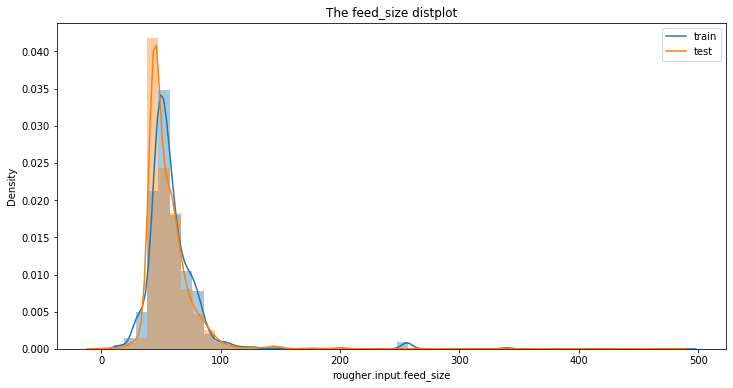

In [35]:
_, ax = plt.subplots(1, figsize=(12,6))

sns.distplot(gold_recovery_train['rougher.input.feed_size'], ax=ax);
sns.distplot(gold_recovery_test['rougher.input.feed_size'], ax=ax);
ax.legend(['train', 'test'])
ax.title.set_text('The feed_size distplot')

Распределения размеров гранул сырья на обучающей и тестовой выборках почти совпадают.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

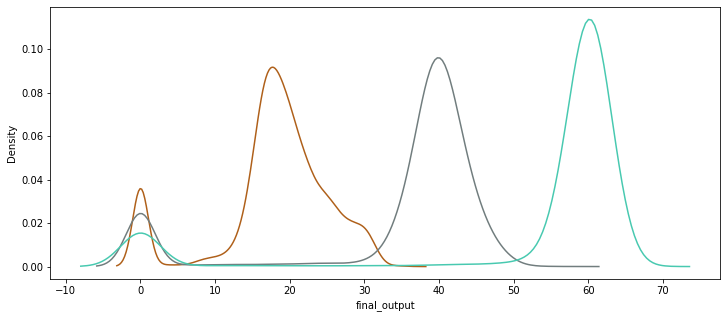

In [36]:
gold_recovery_train['rougher_input'] = gold_recovery_train[
    ['rougher.input.feed_ag','rougher.input.feed_au',
     'rougher.input.feed_pb']].apply(sum, axis=1)

gold_recovery_train['rougher_output'] = gold_recovery_train[
    ['rougher.output.concentrate_ag','rougher.output.concentrate_au',
     'rougher.output.concentrate_pb']].apply(sum, axis=1)

gold_recovery_train['final_output'] = gold_recovery_train[
    ['final.output.concentrate_ag','final.output.concentrate_au', 
     'final.output.concentrate_pb']].apply(sum, axis=1)

_, ax = plt.subplots(figsize=(12,5))
sns.distplot(gold_recovery_train['rougher_input'], ax=ax, hist=False, 
             color='#AF601A', label='rougher_input')
sns.distplot(gold_recovery_train['rougher_output'], ax=ax, hist=False, 
             color='#717D7E', label='rougher_output')
sns.distplot(gold_recovery_train['final_output'], ax=ax, hist=False, 
             color='#48C9B0', label='final_output')
plt.show()

Присутствуют суммарные концентрации на всех 3 стадиях. Удалим, так как их присутствие плохо скажется на качестве модели.

In [37]:
concentrates_outliers = ((gold_recovery_train['rougher_input'] == 0) |
                         (gold_recovery_train['rougher_output'] == 0) |
                         (gold_recovery_train['final_output'] == 0))

print(gold_recovery_train[concentrates_outliers].shape)
gold_recovery_train.shape

(1732, 91)


(16860, 91)

In [38]:
gold_recovery_train.drop(gold_recovery_train[concentrates_outliers].index, 
                         axis=0, inplace=True)
gold_recovery_train.shape

(15128, 91)

Удалим из обучающей выборки признаки, которые отсутствуют в тестовой выборке.

In [39]:
gold_recovery_train.drop(drop_list, inplace=True, axis=1)
print(gold_recovery_train.shape)
print(gold_recovery_test.shape)

(15128, 58)
(5856, 53)


In [40]:
set(gold_recovery_train.columns)-set(gold_recovery_test.columns)

{'final.output.recovery',
 'final_output',
 'rougher.output.recovery',
 'rougher_input',
 'rougher_output'}

In [41]:
gold_recovery_train.drop(['final_output','rougher_input','rougher_output'],
                         inplace=True, axis=1)
print(gold_recovery_train.shape)
print(gold_recovery_test.shape)

(15128, 55)
(5856, 53)


Посмотрим на матрицу корреляции оставшихся признаков.

In [42]:
corr_matrix = gold_recovery_train.corr()
corr_matrix[[rougher_target, final_target]]

,rougher.output.recovery,final.output.recovery
final.output.recovery,0.384161,1.000000
primary_cleaner.input.sulfate,0.380769,0.123334
primary_cleaner.input.depressant,0.163856,-0.034826
primary_cleaner.input.feed_size,-0.015361,0.027780
primary_cleaner.input.xanthate,0.187651,0.020347
primary_cleaner.state.floatbank8_a_air,0.133806,-0.248453
primary_cleaner.state.floatbank8_a_level,0.049598,-0.259944
primary_cleaner.state.floatbank8_b_air,0.143704,-0.235127
primary_cleaner.state.floatbank8_b_level,0.049082,-0.274474
primary_cleaner.state.floatbank8_c_air,0.155865,-0.244499


<img src="https://miro.medium.com/max/466/1*Qz_gwy4ZaSZuOpl3IyO2HA.png" title="Значения коэффициентов корреляции" />



Удалим признаки, которые имеют слабую связь с целевыми признаками.

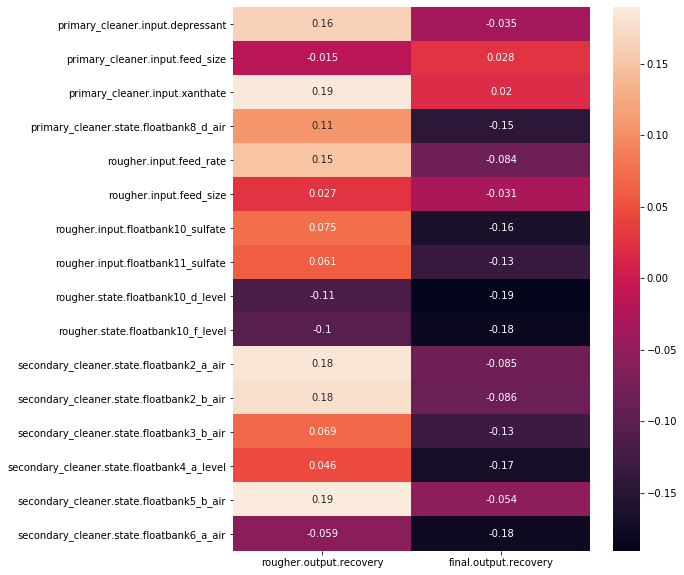

In [43]:
# признаки, имеющие слабую связь с двумя целевыми переменными
mask = ((corr_matrix[rougher_target] < 0.2) & (corr_matrix[rougher_target] > -0.2) &
(corr_matrix[final_target] < 0.2) & ( corr_matrix[final_target] > -0.2))

_, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(corr_matrix[mask][[rougher_target, final_target]], annot=True, ax=ax)
plt.show()

In [44]:
# удалим "слабые" признаки
drop_list_corr = corr_matrix[mask][[rougher_target, final_target]].index

print(gold_recovery_train.shape)
print(gold_recovery_test.shape)

gold_recovery_train.drop(drop_list_corr, inplace=True, axis=1)
gold_recovery_test.drop(drop_list_corr, inplace=True, axis=1)

print(gold_recovery_train.shape)
print(gold_recovery_test.shape)

(15128, 55)
(5856, 53)
(15128, 39)
(5856, 37)


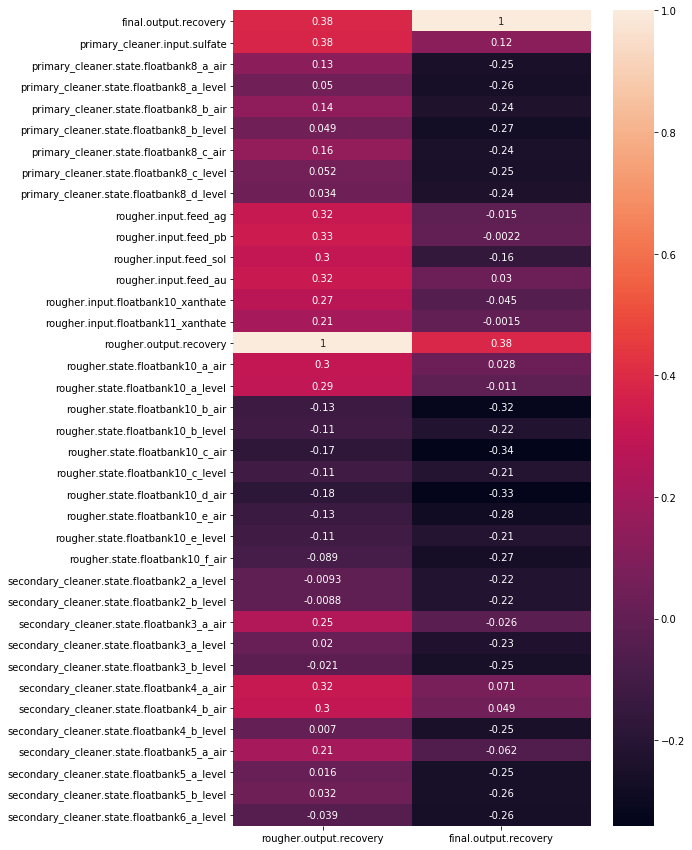

In [45]:
# оставшиеся признаки
corr_matrix = gold_recovery_train.corr()
_, ax = plt.subplots(figsize=(8, 15))
sns.heatmap(corr_matrix[[rougher_target, final_target]], annot=True, ax=ax)
plt.show()

Из таблицы видно, что набор признаков избыточен - некоторые признаки "сильные" для одного таргета, а "слабые" для другого. Разделим для каждого таргета набор признаков.

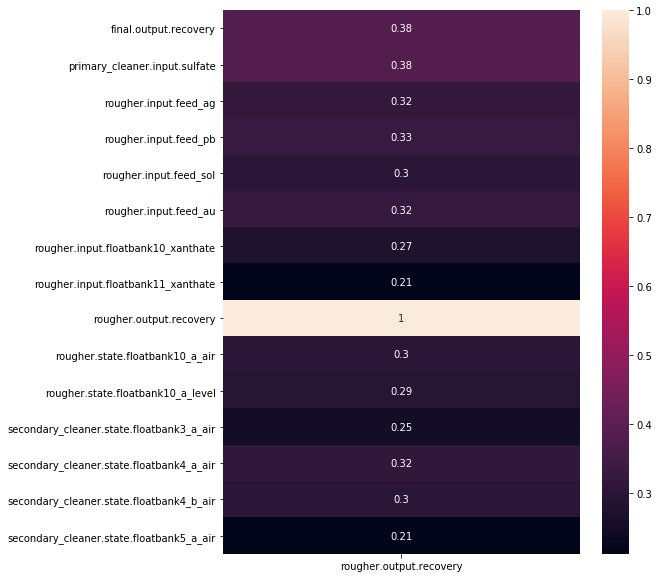

13

In [46]:
rougher_mask = ((corr_matrix[rougher_target] >= 0.2) | (corr_matrix[rougher_target] <= -0.2))

_, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(corr_matrix[rougher_mask][[rougher_target]], annot=True, ax=ax)
plt.show()

rougher_features = list(set(corr_matrix[rougher_mask][[rougher_target]].index)
                        - set([rougher_target])
                        - set([final_target])
                       )
len(rougher_features)

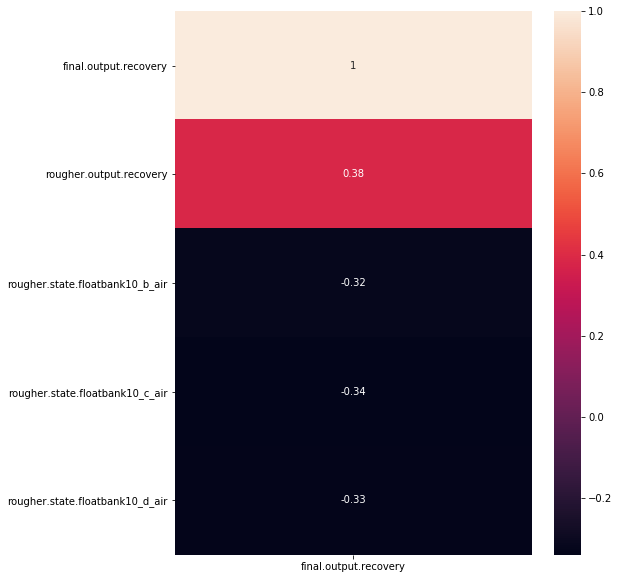

3

In [47]:
# final_mask = ((corr_matrix[final_target] >= 0.2) | (corr_matrix[final_target] <= -0.2))
final_mask = ((corr_matrix[final_target] >= 0.3) | (corr_matrix[final_target] <= -0.3))

_, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(corr_matrix[final_mask][[final_target]], annot=True, ax=ax)
plt.show()

final_features = list(set(corr_matrix[final_mask][[final_target]].index)
                        - set([rougher_target])
                        - set([final_target])
                       )

len(final_features)

В  полной и обучающей выборке заменим 0 в целевых признаках на 0.000001. Затем дополним тестовую выборку целевым признаком.

In [48]:
for df in [gold_recovery_train, gold_recovery_full]:
    for feature in ['rougher.output.recovery', 'final.output.recovery']:
        df[feature] = df[feature].replace(0, 0.000001)

In [49]:
print(gold_recovery_test.shape)

target_df = gold_recovery_full[['date', 'final.output.recovery', 'rougher.output.recovery']]
gold_recovery_test = gold_recovery_test.merge(target_df, on='date', how='left')

print(gold_recovery_test.shape)
gold_recovery_test.isna().sum().sum()

(5856, 37)
(5856, 39)


0

In [50]:
gold_recovery_train.drop('date', inplace=True, axis=1)
gold_recovery_test.drop('date', inplace=True, axis=1)

## 5. Модель

Разделим признаки и целевую переменную.

In [51]:
# обучающая выборка
rougher_X_train = gold_recovery_train[rougher_features]
rougher_y_train = gold_recovery_train['rougher.output.recovery']

final_X_train = gold_recovery_train[final_features]
final_y_train = gold_recovery_train['final.output.recovery']

rougher_scaler = StandardScaler().fit(rougher_X_train)
rougher_X_train_scaled = rougher_scaler.transform(rougher_X_train)

final_scaler = StandardScaler().fit(final_X_train)
final_X_train_scaled = final_scaler.transform(final_X_train)

# тестовая выборка
rougher_X_test = gold_recovery_test[rougher_features]
rougher_y_test = gold_recovery_test['rougher.output.recovery']
    
final_X_test = gold_recovery_test[final_features]
final_y_test = gold_recovery_test['final.output.recovery']

rougher_X_test_scaled = rougher_scaler.transform(rougher_X_test)
final_X_test_scaled = final_scaler.transform(final_X_test)

# константная модель
rougher_const = [rougher_y_train.median()] * len(rougher_y_train)
final_const = [final_y_train.median()] * len(final_y_train)


In [52]:
rougher_lg, final_lg = get_results(learn_LinR, rougher_X_train_scaled, 
                                   rougher_y_train, rougher_const, 
                                   final_X_train_scaled, 
                                   final_y_train, final_const
                                  )

---------------------------------------------------
rougher learn_LinR sMAPE train: 9.017436998041939
rougher learn_LinR sMAPE const: 8.253440636966964
diff: -9.0%
---------------------------------------------------
final  learn_LinR sMAPE train: 11.682365507368496
final  learn_LinR sMAPE const: 11.672374592588229
diff: -0.0%
---------------------------------------------------
Total sMAPE [train]: 11.016133380036857
Total sMAPE [const]: 10.817641103682913
diff: -2.0%
---------------------------------------------------


In [53]:
rougher_dt, final_dt = get_results(learn_DT, rougher_X_train_scaled, 
                                   rougher_y_train,
                                   rougher_const, final_X_train_scaled, 
                                   final_y_train,
                                   final_const)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  73 out of  80 | elapsed:    3.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The best train MAE: 6.731250318828242
{'min_samples_leaf': 6, 'min_impurity_split': 0.2, 'max_features': 'sqrt', 'max_depth': 10}

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best train MAE: 8.651273739788115
{'min_samples_leaf': 1, 'min_impurity_split': 0.4, 'max_features': 'sqrt', 'max_depth': 10}

---------------------------------------------------
rougher learn_DT sMAPE train: 4.693308282848519
rougher learn_DT sMAPE const: 8.253440636966964
diff: 43.0%
---------------------------------------------------
final  learn_DT sMAPE train: 9.79355611714216
final  learn_DT sMAPE const: 11.672374592588229
diff: 16.0%
---------------------------------------------------
Total sMAPE [train]: 8.51849415856875
Total sMAPE [const]: 10.817641103682913
diff: 21.0%
---------------------------------------------------


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished


In [54]:
# INFO: долго, наилучшие результаты вынесены в отдельный блок
# 
# rougher_rf, final_rf = get_results(learn_RF, rougher_X_train_scaled, 
#                                    rougher_y_train,
#                                    rougher_const, final_X_train_scaled, 
#                                    final_y_train,
#                                    final_const)

Вычисление итоговой sMAPE.

<img src="https://pictures.s3.yandex.net/resources/smape_1576239058.jpg" title="sMAPE" />
<img src="https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg" title="Итоговое sMAPE" />

In [55]:
# как итог для rougher - лучшая модель
m = RandomForestRegressor(random_state=12345, 
                          n_estimators=30,
                          min_weight_fraction_leaf=0.0,
                          min_samples_leaf=8, 
                          min_impurity_split=0.6, 
                          min_impurity_decrease=0.0, 
                          max_features='sqrt',
                          max_depth=45)

results = cross_validate(m, rougher_X_train_scaled, rougher_y_train, cv=5, 
                         scoring=make_scorer(smape), return_estimator=True)
# results
rougher_rf = results['estimator'][0]
rougher_rf.fit(rougher_X_train_scaled, rougher_y_train)
smape_train = smape(rougher_y_train, rougher_rf.predict(rougher_X_train_scaled)) 
smape_train
#     smape_const = smape(y_train, y_const)

3.3272158114569272

In [56]:
# как итог для final - лучшая модель
m = RandomForestRegressor(random_state=12345, n_estimators=30, 
                          min_weight_fraction_leaf=0.2, min_samples_leaf=1, 
                          min_impurity_split=0.4, min_impurity_decrease=0.3, 
                          max_features='sqrt', max_depth=75)

results = cross_validate(m, rougher_X_train_scaled, rougher_y_train, cv=5, 
                         scoring=make_scorer(smape), return_estimator=True)
# results
final_rf = results['estimator'][0]
final_rf.fit(final_X_train_scaled, final_y_train)
smape(final_y_train, final_rf.predict(final_X_train_scaled))

11.070672870359912

Лучшие результаты показала модель **Случайный лес**.

In [57]:
test_model(rougher_rf, final_rf, 
           rougher_X_test_scaled, rougher_y_test, 
           rougher_const,
           final_X_test_scaled, final_y_test, 
           final_const)

---------------------------------------------------
rougher  sMAPE test: 9.086831011113789
rougher  sMAPE const: 9.402804647736467
diff: 3.0%
---------------------------------------------------
final   sMAPE test: 13.233212388654215
final   sMAPE const: 12.710803179743888
diff: -4.0%
---------------------------------------------------
Total sMAPE [test]: 12.196617044269107
Total sMAPE [const]: 11.883803546742032
diff: -3.0%
---------------------------------------------------


## Вывод

В результате тестирования имеем следующую разницу метрики sMAPE по сравнению с константной моделью:
* rougher.output.recovery - 1%
* final.output.recovery - ~ -4%
* итоговый - ~ -3%